In [8]:
!python.exe -m pip install --upgrade pip
!pip install pandas numpy scikit-learn seaborn category_encoders matplotlib --quiet

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score)
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Incarcarea datelor

In [9]:
dfs = []
for i in range(1,5):
    path = './data/UNSW-NB_complet/UNSW-NB15_{}.csv'  
    dfs.append(pd.read_csv(path.format(i), header=None, low_memory=False))
df = pd.concat(dfs).reset_index(drop=True)

df_col = pd.read_csv('./data/UNSW-NB_complet/NUSW-NB15_features.csv', encoding='ISO-8859-1')
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())
df.columns = df_col['Name']

cols_to_drop_total = [
    'srcip', 'dstip', 'stime', 'ltime',
    'dsport', 'sport',
    'attack_cat',
    'stcpb', 'dtcpb',
    'trans_depth', 'res_bdy_len',
    'is_ftp_login', 'ct_flw_http_mthd', 'ct_ftp_cmd',
    'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
    'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'
]
df.drop(columns=cols_to_drop_total, inplace=True)

# eliminam duplicatele
df = df.drop_duplicates().reset_index(drop=True)

# split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# verificam disjunctia prin index (doar informativ)
train_idx = df_train.index
test_idx = df_test.index
common_idx = train_idx.intersection(test_idx)
print(f'Intersectie dupa index: {len(common_idx)} randuri comune')


Intersectie dupa index: 0 randuri comune


# Preprocesarea datelor

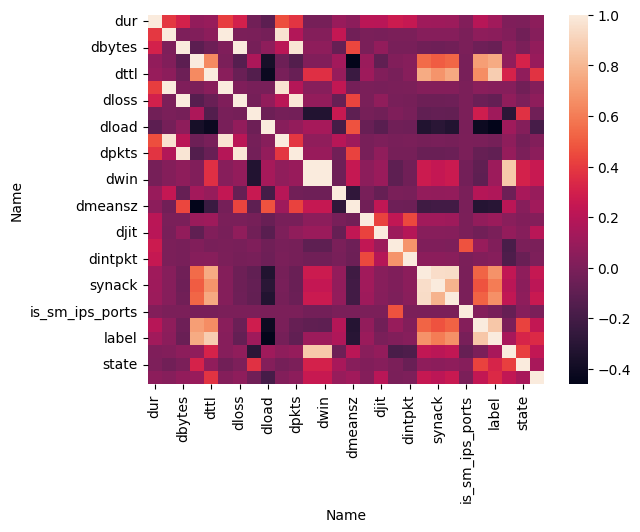

In [10]:
# balansare simpla (resampling) in train si test
from sklearn.utils import resample

malign_train = df_train[df_train['label'] == 1]
benign_train = df_train[df_train['label'] == 0]
n = min(len(malign_train), len(benign_train))
malign_train = resample(malign_train, replace=True, n_samples=n, random_state=42)
benign_train = resample(benign_train, replace=True, n_samples=n, random_state=42)
df_train = pd.concat([malign_train, benign_train]).sample(frac=1, random_state=42).reset_index(drop=True)

malign_test = df_test[df_test['label'] == 1]
benign_test = df_test[df_test['label'] == 0]
n = min(len(malign_test), len(benign_test))
malign_test = resample(malign_test, replace=True, n_samples=n, random_state=42)
benign_test = resample(benign_test, replace=True, n_samples=n, random_state=42)
df_test = pd.concat([malign_test, benign_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# encodare si eliminare corelatii puternice
transform_cols = ['proto', 'state', 'service']
encoder = TargetEncoder(cols=transform_cols, handle_unknown='value')

df_train_encoded = encoder.fit_transform(df_train[transform_cols], df_train['label'])
df_train_rest = df_train.drop(columns=transform_cols)
df_train = pd.concat([df_train_rest, df_train_encoded], axis=1)

df_test_encoded = encoder.transform(df_test[transform_cols])
df_test_rest = df_test.drop(columns=transform_cols)
df_test = pd.concat([df_test_rest, df_test_encoded], axis=1)

# vizualizare corelatii
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=False)

# eliminare features foarte corelate (> 0.9)
corr_matrix_abs = df_train.corr().abs()
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.9)]
if 'label' in to_drop:
    to_drop.remove('label')
df_train = df_train.drop(columns=to_drop)
df_test = df_test.drop(columns=to_drop)

# Gini-Weighted Random Forest criterion

In [11]:
# selectie de feature-uri folosind RandomForest
X = df_train.drop(columns=['label'])
y = df_train['label']

giwrf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
giwrf.fit(X, y)

feature_importances = pd.Series(giwrf.feature_importances_, index=X.columns)
threshold = 0.02
selected_features = feature_importances[feature_importances > threshold].index.tolist()

df_train = df_train[selected_features + ['label']]
df_test = df_test[selected_features + ['label']]


# Scalarea atributelor

In [12]:
x_train = df_train.drop(columns=['label'])
y_train = df_train['label']
x_test = df_test.drop(columns=['label'])
y_test = df_test['label']

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


# Antrenarea modelului

Best params KNN: {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best CV score (F1): 0.9931070704551118

=== KNN Classification Report (test) ===
Accuracy: 0.9921
              precision    recall  f1-score   support

      Benign       1.00      0.98      0.99     12003
   Malicious       0.98      1.00      0.99     12003

    accuracy                           0.99     24006
   macro avg       0.99      0.99      0.99     24006
weighted avg       0.99      0.99      0.99     24006



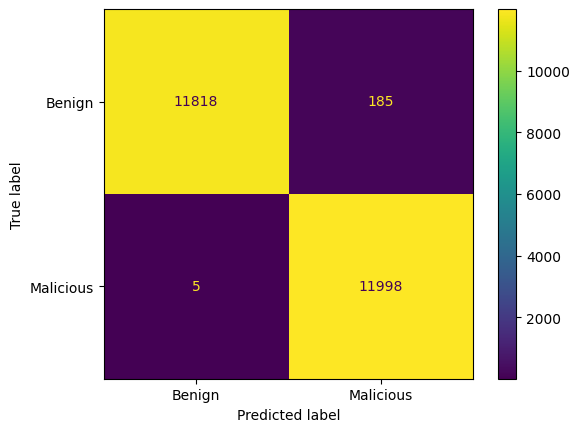

In [13]:

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='f1', n_jobs=-1, cv=cv, verbose=0)
grid.fit(x_train_scaled, y_train)

print("Best params KNN:", grid.best_params_)
print("Best CV score (F1):", grid.best_score_)

best_knn = grid.best_estimator_
y_pred_knn = best_knn.predict(x_test_scaled)

print("\n=== KNN Classification Report (test) ===")
acc = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred_knn, target_names=['Benign', 'Malicious']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, display_labels=['Benign', 'Malicious'])

# Cross Validation


Acuratete medie pe validare (KNN): 0.9931
Deviatie standard: 0.0003

--- Clasa 0 ---
Precizie medie: 0.9999
Recall mediu:   0.9862
F1-score mediu: 0.9930

--- Clasa 1 ---
Precizie medie: 0.9864
Recall mediu:   0.9999
F1-score mediu: 0.9931

Matricea de confuzie medie (KNN):
[[9250  129]
 [   0 9379]]


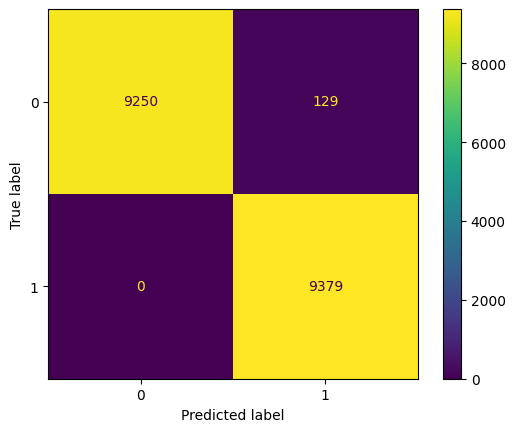

In [ ]:

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precisions_per_class, recalls_per_class, f1_scores_per_class = [], [], []
conf_matrices, accuracies = [], []

for train_idx, val_idx in kf.split(x_train_scaled, y_train):
    X_train_fold = x_train_scaled[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = x_train_scaled[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    knn_fold = KNeighborsClassifier(**grid.best_params_)
    knn_fold.fit(X_train_fold, y_train_fold)
    y_pred = knn_fold.predict(X_val_fold)

    acc = accuracy_score(y_val_fold, y_pred)
    prec = precision_score(y_val_fold, y_pred, average=None, labels=[0, 1])
    rec = recall_score(y_val_fold, y_pred, average=None, labels=[0, 1])
    f1 = f1_score(y_val_fold, y_pred, average=None, labels=[0, 1])
    cm = confusion_matrix(y_val_fold, y_pred)

    accuracies.append(acc)
    precisions_per_class.append(prec)
    recalls_per_class.append(rec)
    f1_scores_per_class.append(f1)
    conf_matrices.append(cm)

precisions_per_class = np.array(precisions_per_class)
recalls_per_class = np.array(recalls_per_class)
f1_scores_per_class = np.array(f1_scores_per_class)

print(f"\nAcuratete medie pe validare (KNN): {np.mean(accuracies):.4f}")
print(f"Deviatie standard: {np.std(accuracies):.4f}")

for i, cls in enumerate([0, 1]):
    print(f"\n--- Clasa {cls} ---")
    print(f"Precizie medie: {np.mean(precisions_per_class[:, i]):.4f}")
    print(f"Recall mediu:   {np.mean(recalls_per_class[:, i]):.4f}")
    print(f"F1-score mediu: {np.mean(f1_scores_per_class[:, i]):.4f}")

conf_matrix_avg = np.mean(conf_matrices, axis=0).astype(int)
print("\nMatricea de confuzie medie (KNN):")
print(conf_matrix_avg)
ConfusionMatrixDisplay(conf_matrix_avg).plot(cmap='viridis')

# Articol pentru comparatie
# https://www.researchgate.net/publication/360392171_Analysis_of_UNSW-NB15_Datasets_Using_Machine_Learning_Algorithms
